In [1]:
import os
import tqdm
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import kagglehub

/home/amcalinden/miniconda3/envs/diffusion2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def set_seeds(seed):
    """Sets the seed for reproducible results across different libraries."""
    random.seed(seed) # Python's built-in random
    np.random.seed(seed) # NumPy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # PyTorch CUDA for all available GPUs
        # Optional: Additional settings for full CUDA reproducibility
        # Note: These might slow down execution
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

def write_to_disk(unet, path):
    unet.save_pretrained(path)
    print(f"Unet saved to {path}")

def load_from_disk(path):
    unet = torch.load(path)
    print(f"Unet loaded from {path}")

    total_params = sum(p.numel() for p in unet.parameters())
    trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return unet

In [3]:
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/amcalinden/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7


In [4]:
path_train = os.path.join(path, "train")
outer_dir = os.listdir(path_train)
print("Num Classes:", len(outer_dir))
classes = []
for subfolder in outer_dir:
    subfolder_path = os.path.join(path_train, subfolder)
    if os.path.isdir(subfolder_path):
        inner_size = len(os.listdir(subfolder_path))
        classes.append((inner_size, subfolder))
classes.sort(reverse=True)
print("Classes sorted by number of images:")
for size, name in classes:
    print(f"  {name}: {size} images")

Num Classes: 80
Classes sorted by number of images:
  Butterfly: 1876 images
  Moths and butterflies: 1430 images
  Lizard: 1201 images
  Spider: 857 images
  Fish: 836 images
  Monkey: 771 images
  Eagle: 720 images
  Frog: 589 images
  Snake: 563 images
  Duck: 543 images
  Caterpillar: 495 images
  Sparrow: 476 images
  Jellyfish: 458 images
  Parrot: 422 images
  Owl: 407 images
  Horse: 401 images
  Ladybug: 393 images
  Tortoise: 392 images
  Chicken: 389 images
  Penguin: 378 images
  Snail: 371 images
  Squirrel: 368 images
  Deer: 328 images
  Tiger: 314 images
  Crab: 310 images
  Shark: 304 images
  Giraffe: 299 images
  Goose: 290 images
  Whale: 288 images
  Starfish: 249 images
  Harbor seal: 241 images
  Sea turtle: 240 images
  Swan: 234 images
  Polar bear: 230 images
  Rabbit: 217 images
  Rhinoceros: 215 images
  Lion: 209 images
  Goat: 203 images
  Centipede: 195 images
  Pig: 191 images
  Sea lion: 189 images
  Zebra: 182 images
  Woodpecker: 172 images
  Elephant

In [5]:
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    image_size = 128
    num_classes = 11
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    num_ddpm_steps = 1000
    num_epochs = 60
    lr = 1e-4
    num_warmup_steps = 500
    scale_factor= 0.18215
    seed = 423432

config = Hyperparameters()
set_seeds(config.seed)

Random seed set to 423432


In [6]:
top_classes = [tup[1] for tup in classes[:config.num_classes]]
print("Using classes:", top_classes)

Using classes: ['Butterfly', 'Moths and butterflies', 'Lizard', 'Spider', 'Fish', 'Monkey', 'Eagle', 'Frog', 'Snake', 'Duck', 'Caterpillar']


In [7]:
import AnimalDataset
from torch.utils.data import DataLoader

import importlib
importlib.reload(AnimalDataset)

print("Using device:", config.device)
dataset = AnimalDataset.AnimalDataset(path_train, top_classes, config.image_size, config.device)
train_loader = DataLoader(
    dataset,
    config.batch_size,
    shuffle=True,
)

Using device: cuda:1
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])
shape of text embedding: torch.Size([1, 768])


Image shape: torch.Size([64, 3, 128, 128])
Embedding shape: torch.Size([64, 1, 768])


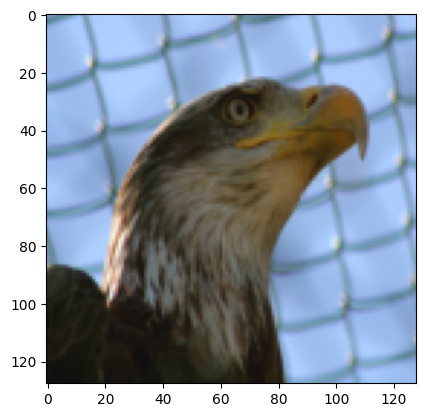

In [8]:
for img, embedding in train_loader:
    print("Image shape:", img.shape)
    print("Embedding shape:", embedding.shape)
    img_show = (img + 1) / 2
    plt.imshow(img_show[0].permute(1, 2, 0).cpu())
    plt.show()
    break

In [ ]:
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler

# same as the one used in stable diffusion
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32)
vae.eval()
vae.requires_grad_(False)
vae.to(config.device)

unet = UNet2DConditionModel(cross_attention_dim = (768),
                                    down_block_types = ("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
                                    block_out_channels= (320, 640, 1280),
                                    up_block_types = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
                                    ).to(torch.float32)
unet.requires_grad_(True)
unet.to(config.device)

total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_ddpm_steps)

Total parameters: 446,450,884
Trainable parameters: 446,450,884


In [10]:
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.num_warmup_steps,
    num_training_steps=(len(train_loader) * config.num_epochs),
)

In [23]:
def train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler, start_epoch=0):
    vae.eval()
    unet.train()

    losses = []
    for epoch in range(start_epoch, start_epoch + config.num_epochs):
        total_loss = 0
        for imgs, embeddings in tqdm.tqdm(train_loader):
            imgs = imgs.to(config.device)
            embeddings = embeddings.to(config.device)

            with torch.no_grad():
                latents = vae.encode(imgs).latent_dist.sample()
                latents *= config.scale_factor

            batch_size = imgs.shape[0]
            noise = torch.randn(latents.shape).to(config.device)
            timesteps = torch.randint(0, config.num_ddpm_steps, (batch_size,)).to(config.device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings.detach()).sample

            loss = F.mse_loss(model_pred, noise, reduction="mean")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

            del loss, model_pred, noisy_latents, noise, timesteps, latents
            torch.cuda.empty_cache()


        print(f"Epoch {epoch + 1}/{config.num_epochs + start_epoch}, Loss: {total_loss / len(train_loader)}")
        losses.append(total_loss / len(train_loader))
    return losses

In [12]:
losses = train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler)

100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 1/60, Loss: 0.4165517295560529


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 2/60, Loss: 0.2081474134518254


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 3/60, Loss: 0.18982258160268106


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 4/60, Loss: 0.1831054130869527


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 5/60, Loss: 0.1815030708428352


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 6/60, Loss: 0.18050261149483343


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 7/60, Loss: 0.17198157608509063


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 8/60, Loss: 0.17833429536511822


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 9/60, Loss: 0.17282714545726777


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 10/60, Loss: 0.17171843340319973


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 11/60, Loss: 0.17774315875384114


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 12/60, Loss: 0.1734678689029909


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 13/60, Loss: 0.16666337126685726


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 14/60, Loss: 0.1714808838982736


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 15/60, Loss: 0.16899604114793962


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 16/60, Loss: 0.17155999046179557


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 17/60, Loss: 0.16839888216026366


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 18/60, Loss: 0.16935451323947598


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 19/60, Loss: 0.1638103431751651


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 20/60, Loss: 0.1662966960860837


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 21/60, Loss: 0.16414440029090452


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 22/60, Loss: 0.16993599793603342


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 23/60, Loss: 0.16370915842633094


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 24/60, Loss: 0.1634953077281675


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 25/60, Loss: 0.1667417835804724


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 26/60, Loss: 0.1629457916463575


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 27/60, Loss: 0.16009226071257746


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 28/60, Loss: 0.164368463475858


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 29/60, Loss: 0.1635425077811364


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 30/60, Loss: 0.16528387040861192


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 31/60, Loss: 0.16433639925333762


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 32/60, Loss: 0.16096617252595963


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 33/60, Loss: 0.15968037170748556


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 34/60, Loss: 0.16183630453963432


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 35/60, Loss: 0.1646621362816903


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 36/60, Loss: 0.16183222325578814


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 37/60, Loss: 0.16056801003794516


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 38/60, Loss: 0.16358628032668945


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 39/60, Loss: 0.15981227371000475


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 40/60, Loss: 0.16148078946336622


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 41/60, Loss: 0.16229033061573583


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 42/60, Loss: 0.1623064214183438


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 43/60, Loss: 0.1589914787680872


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 44/60, Loss: 0.16116561553170605


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 45/60, Loss: 0.16055252922158086


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 46/60, Loss: 0.16037554313098232


100%|██████████| 155/155 [02:45<00:00,  1.07s/it]


Epoch 47/60, Loss: 0.1565097774228742


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 48/60, Loss: 0.16008419250288317


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 49/60, Loss: 0.15479116314841854


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 50/60, Loss: 0.1543091366848638


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 51/60, Loss: 0.1556515126939743


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 52/60, Loss: 0.15787734187418415


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 53/60, Loss: 0.15893626179425946


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 54/60, Loss: 0.15485208375800041


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 55/60, Loss: 0.1575299638413614


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 56/60, Loss: 0.1560197723007971


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 57/60, Loss: 0.15999227444971761


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 58/60, Loss: 0.15479873625501508


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 59/60, Loss: 0.15228456398171764


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]

Epoch 60/60, Loss: 0.16079929730584544


Text(0, 0.5, 'Loss')

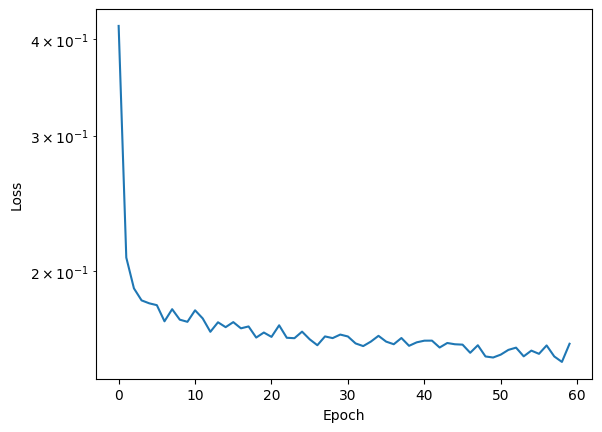

In [ ]:
def plot_losses(losses):
    plt.semilogy(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
plot_losses(losses)

In [ ]:
losses_2 = train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler, start_epoch=config.num_epochs)
full_losses = losses + losses_2
plot_losses(full_losses)

100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 61/120, Loss: 0.1572681307311981


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 62/120, Loss: 0.1616207282389364


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 63/120, Loss: 0.15466813565261903


100%|██████████| 155/155 [02:43<00:00,  1.05s/it]


Epoch 64/120, Loss: 0.1564656302332878


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 65/120, Loss: 0.16183177732652235


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 66/120, Loss: 0.1607354858229237


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 67/120, Loss: 0.15535811084893442


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 68/120, Loss: 0.15486052531388497


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 69/120, Loss: 0.15294181267099996


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 70/120, Loss: 0.15742901957804156


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 71/120, Loss: 0.15972505452171448


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 72/120, Loss: 0.16654305751285245


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 73/120, Loss: 0.15673075683655277


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 74/120, Loss: 0.15732155076919063


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 75/120, Loss: 0.15582362754691031


100%|██████████| 155/155 [02:44<00:00,  1.06s/it]


Epoch 76/120, Loss: 0.1601030934722193


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 77/120, Loss: 0.15765795565901264


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 78/120, Loss: 0.15811777850312572


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 79/120, Loss: 0.1568138466727349


100%|██████████| 155/155 [02:43<00:00,  1.06s/it]


Epoch 80/120, Loss: 0.16412923393710968


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 81/120, Loss: 0.16027873663171646


100%|██████████| 155/155 [02:41<00:00,  1.04s/it]


Epoch 82/120, Loss: 0.1557273903681386


100%|██████████| 155/155 [02:41<00:00,  1.04s/it]


Epoch 83/120, Loss: 0.15814780381418045


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 84/120, Loss: 0.15904659047242134


100%|██████████| 155/155 [02:42<00:00,  1.05s/it]


Epoch 85/120, Loss: 0.16314878151301415


100%|██████████| 155/155 [02:41<00:00,  1.04s/it]


Epoch 86/120, Loss: 0.16301049695860956


 87%|████████▋ | 135/155 [02:20<00:20,  1.05s/it]

In [14]:
latent_shape = None
for imgs, embeddings in train_loader:
    imgs = imgs.to(config.device)
    embeddings = embeddings.to(config.device)
    latent = vae.encode(imgs).latent_dist.sample()
    latent_shape = latent.shape
    break
print("Latent shape:", latent_shape)

Latent shape: torch.Size([64, 4, 16, 16])


In [15]:
def sample_from_model(config, vae, unet, noise_scheduler, text_embedding, latent_shape, num_samples=20):
    vae.eval()
    unet.eval()

    text_embedding = text_embedding.unsqueeze(0)
    text_embedding = text_embedding.expand(num_samples, -1, -1)

    latent_shape = torch.Size((num_samples,) + latent_shape[1:])
    latents = torch.randn(latent_shape).to(config.device)
    # latents *= config.scale_factor

    with torch.no_grad():
        for i in noise_scheduler.timesteps:
            # latent_inputs = noise_scheduler.scale_model_input(latents, i)
            model_pred = unet(latents, i, encoder_hidden_states=text_embedding).sample
            latents = noise_scheduler.step(model_pred, i, latents).prev_sample
        images = vae.decode(latents / config.scale_factor).sample
        images = (images / 2) + 0.5
        images = torch.clamp(images, 0, 1)
        return images

In [16]:
def make_grid(images, ncols=4):
    n = len(images)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()
    for i in range(n):
        axs[i].imshow(images[i].permute(1, 2, 0).cpu())
        axs[i].axis("off")
    for i in range(n, nrows * ncols):
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
all_samples = []
cols = 6
for num_images, text in classes:
    print("Sampling images for class:", text)
    embedding = dataset.label_to_text_embedding[text]
    samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
    all_samples.append(samples)
make_grid(all_samples, ncols=cols)

Sampling images for class: Eagle


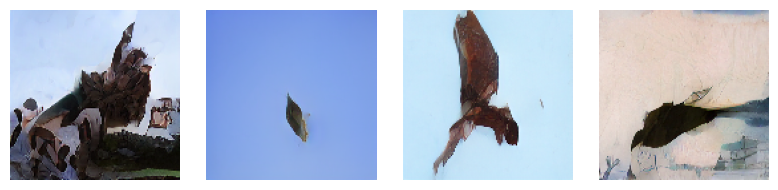

In [ ]:
text = "Salamander"
print("Sampling images for class:", text)
embedding = dataset.get_embedding(text)
samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
make_grid(samples, ncols=cols)

In [ ]:
write_to_disk(unet, "top10_400m_120epoch")

Unet saved to top10_400m_60epoch
